# Denoise

In [1]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../..")))
import cv2
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from skimage.util import random_noise

from bcd.preprocess.image.denoise.analyze import MeanFilterAnalyzer, GaussianFilterAnalyzer, MedianFilterAnalyzer

What is noise? Somewhat imprecisely, we might say that noise is any variation in brightness information not part of the original image. Yet, all biomedical images are imperfect representations of the underlying structure that is being imaged. Limited resolution (defined by the optics), uneven illumination or background, out-of-focus light, artifacts, and, of course, image noise, contribute to this imperfection. For denoising, we distinguish noise from other imperfections, with the following definition:

> Noise is the discrepancy between the true amount of light $s_i$ being measured at pixel $i$, and the corresponding measured pixel value $x_i$.

In the following subsections, we expand on this definition with a review of the most common noise models in digital mammograph. Then, we describe the predominate types of noises encountered in digital mammography.  Next, we introduce the most frequently applied denoising methods in low-dose X-ray mammography. Finally, we conduct an evaluation to determine the denoiser that produces the best results.

## Noise Models

Broadly speaking, noise can be modeled as additive, multiplicative, or impulse.

### Additive Noise Model

The additive noise model describes the abrupt, and undesired signal that gets added to an image, and is given by:

```{math}
:label: additive_noise_model
f(x,y)=s(x,y)+n(x,y)
```

where:

- $x$ and $y$ are the coordinates of the pixel to which the noise is applied;
- $f(x,y)$ is the observed noisy image;
- $s(x,y)$ is the noise-free image signal which has been corrupted by a noise process;
- $n(x,y)$ is the signal-independent, random noise that is added to the original noise-free image.

Additive noise, the most common decomposition, can arise from numerous sources, including radiation scatter from the surface before the image is sensed; electrical noise in image sensors, random charge fluctuations induced by thermal noise, environmental electromagnetic interference, and noise associated with the acquisition system. However, dominant source of additive noise in X-ray mammography is the digitization process {cite}`bovikHandbookImageVideo2000`.

### Multiplicative Noise Model

Multiplicative noise ({eq}`multiplicative_noise_model`), by contrast, refers to the unwanted random signal that gets *multiplied* into an image during signal capture, transmission, or other processing.

```{math}
:label: multiplicative_noise_model
f(x,y)=s(x,y)\times n(x,y)
```

where:

- $x$ and $y$ are the coordinates of the pixel to which the noise is applied;
- $f(x,y)$ is the noisy image;
- $s(x,y)$ is the noise-free image;
- $n(x,y)$ refers to signal-dependent, random noise that is multiplied into $s(x,y)$ during image capture, transmission, storage or other processing.

Whereas additive noise is signal independent, multiplicative noise is based on the value of the image pixel; whereby, the amount of noise multiplied into an image pixel is proportional to its intensity.

Note that we can transform a multiplicative noise model to an additive noise model by taking the logarithm of both sides of the multiplication model. The additive model becomes multiplicative by exponentiation.

For instance, {eq}`multiplicative_noise_model` becomes:

```{math}
:label: log_mult_model
log f = log(sn) = log (s) + log (n)
```

Similarly, {eq}`additive_noise_model` becomes:

```{math}
:label: exp_add_model
e^f = e^{s_n} = e^f e^n.
```

A common strategy for addressing multiplicative noise is to convert the noise in the image to additive noise, then apply an appropriate spatial domain filter.

### Impulse Noise Model

Lastly, we have the impulse noise model, which represents a separate mathematical model, neither additive nor multiplicative. Impulse noise arises in the image as a consequence of signal transmission errors. Mathematically, we can describe impulse noise by the following equation.

```{math}
:label: impulse
{f(x,y)} = \begin{cases}
    s(x,y)\text{ with probability 1-P} \\
    s(x,y) + n(x,y) \text{ with probability P}
\end{cases}
```

where:

- 0 \le P \le 1
- $x$ and $y$ are the coordinates of the pixel to which the noise is applied;
- $f(x,y)$ is the noisy image;
- $s(x,y)$ is the noise-free image;
- $n(x,y)$ refers random noise

Higher values of $P$ correspond to greater levels of corruption.

A simplification of {eq}`impulse` for the case in which $n(x,y)$ replaces $s(x,y)$

```{math}
:label: impulse_2
{f(x,y)} = \begin{cases}
    s(x,y)\text{ with probability 1-P} \\
    n(x,y) \text{ with probability P}
\end{cases}
```

Impulse noise can be static or dynamic. In the case of static impulse noise, its pixel values get modified by only two values: either the low or high value in the range of pixel values. For instance, in an 8-bit grayscale image with values ranging from 0 (black) to 255 (white), dark pixels corrupted by impulse noise would be replaced by 255, and white pixels would be replaced by 0. In the case of dynamic impulse noise, pixels are modified independently, with random values between 0 and 255.

Next, we review the types of noise we may encounter.

## Noise Types

The types of noise most inherent in digital mammography are summarized below.

```{table}
:name: noise_types

| Noise                         | Model          | Signal Dependence | Source                            |
|-------------------------------|----------------|-------------------|-----------------------------------|
| Gaussian Noise                | Additive | Independent       | Signal Acquisition / Transmission |
| Quantization Noise            | Additive | Dependent         | Digitization                      |
| Speckle Noise                 | Multiplicative | Dependent         | Signal Detection                  |
| Salt & Pepper Noise           | Impulse   | Independent       | Signal Transmission               |
| Poisson Photon Counting Noise | Neither / Both       | Dependent         | Signal Detection                  |


```

### Gaussian Noise

> "Whenever a large sample of chaotic elements are taken in hand and marshalled in the order of their magnitude, an unsuspected and most beautiful form of regularity proves to have been latent all along." (Sir Francis Galton, 1889)

One of the most significant discoveries in probability theory is the **central limit theorem**, which simply states that the sum of a large number of small independent random variables, under fairly mild conditions, is normally distributed.  This holds even when the underlying random variables are not normally distributed and when the random variables do not have the same distribution.

Gaussian noise arises during data acquisition and is caused by many small, independent random contributions of factors such as:

- thermal vibration of atoms,
- heat variations in image sensors
- random variations in electronic signal, e.g. electronic circuit noise

It is additive in nature, independent at each pixel, independent of signal, and has a probability density {eq}`gaussian_pdf` equal to that of the Gaussian distribution.

```{math}
:label: gaussian_pdf
P(x|\mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
```

where $\mu$ is the mean gray value, and $\sigma$ is the standard deviation.

```{figure} ../../mammogram_gaussian.png
---
name: mammogram_gaussian
---
Mammogram Gaussian Noise

```

In {numref}`mammogram_gaussian` (b) we see the effect of a small amount of noise ($\sigma^2$ = 0.01). In {numref}`mammogram_gaussian` (c), the noise has been increased by a factor of 10 ($\sigma^2 = 0.1$). Notice the overall 'fuzziness'. Increasing the noise by another factor of ten ({numref}`mammogram_gaussian` (d)), the noise is much more objectionable.

### Quantization Noise

Quantization noise arises out of the process of converting a continuous analog image to a discrete digital representation. This Analog to Digital Conversion (ADC) consists of two steps: sampling and quantization. Sampling is the process of digitizing the coordinate values, $x$, and $y$. It defines the spatial resolution or number of pixels of the digitized image. Quantization is the process of digitizing the amplitude or intensity values. This process defines the number of gray levels that each pixel can take.

Quantization noise is an unavoidable aspect of ADC. An analog signal is continuous, with (almost) infinite accuracy, while the digital signal's accuracy depends upon the quantization resolution or number of bits in the ADC. A common assumption is that quantization noise is additive, uniformly distributed, and signal-independent unless the number of quantization levels are small. In which case, the noise is correlated on a pixel-by-pixel basis, and is not uniformly distributed {cite}`bovikHandbookImageVideo2000`.

Let $\triangle$ be the step size, then quantization noise, $q$, is modeled as being mean-centered and uniform between $\frac{-\triangle}{2}$ and $\frac{\triangle}{2}$. The variance is $\frac{\triangle^2}{12}$.

```{figure} ../../mammogram_quantize.png
---
name: mammogram_quantize
---
Mammogram Quantization Noise

```

The image in {numref}`mammogram_quantize` has been quantized to only one bit. Note that fine graduations in intensities are lost. Texturing in the image is lost to large areas of constant gray level. The effect of quantizing to too few bits creates an appearance known as "scalloped".

### Speckle Noise

Speckle noise is signal-dependent, non-Gaussian, multiplicative, and spatial-dependent which makes it one of the more complex image noise models. When an X-ray strikes a surface, it is reflected because of random microscopic variations in the roughness of the surface within one pixel.

```{figure} ../../mammogram_speckle.png
---
name: mammogram_speckle
---
Mammogram Speckle Noise

```

{numref}`mammogram_speckle` illustrates several distributions of speckle degradation.

### Salt and Pepper Noise

Salt and pepper noise arises during Analog to Digital Conversion (ADC) and image transmission due to bit errors. An image degraded by salt and pepper noise has dark pixels in light areas and light pixels in dark backgrounds, giving the image a “salt and pepper” appearance.

Salt and pepper noise is an example of impulse noise and is modeled as follows. Let

- $s(x,y)$ be the original 8-bit image, with minimum and maximum pixels of 0, and 255 respectively,
- $f(x,y)$ be the image after it has been altered by salt and pepper noise, and
- $\alpha$ is the probability that a pixel is affected by salt and pepper noise, typically less than 0.1.

A simple model is as follows:

```{math}
:label: snp
Pr(f=s) = 1 - \alpha
```

```{math}
:label: snp_salt
Pr(f=\text{max}) = \frac{\alpha}{2}
```

```{math}
:label: snp_pepper
Pr(f=\text{min}) = \frac{\alpha}{2}
```

For instance, {numref}`mammogram_snp` shows an 8-bit image with $\alpha=0.3$. Approximately 70%  ($1-\alpha$) of the image is unaltered, and 30% ($\alpha$) of the pixels have been changed to black or white.

```{figure} ../../mammogram_snp.png
---
name: mammogram_snp
---
Mammogram Salt and Pepper Noise
```

### Poisson Noise

Image sensors measure scene irradiance by counting the number of discrete photons incident on the sensor over a given time interval. Since the detection of individual photons can be treated as independent events that follow a random temporal distribution, photon counting can be modeled as a Poisson process. The number of photons $N$ measured by a given sensor element over some time interval $t$ can be described by the standard Poisson distribution:

```{math}
:label: poisson_pdf
Pr(N=k) = \frac{e^{-\lambda t}(\lambda t)^k}{k!}
```

where $\lambda$ is the expected number of photons per unit time interval. The uncertainty described by this distribution is known as photon noise or Poisson noise.

Since the photon count follows a Poisson distribution, it has the property that the variance, $Var[N]$ is equal to the expectation, $E[N]$. This shows that photon noise is signal-dependent and that the standard deviation grows with the square root of the signal.

```{figure} ../../mammogram_poisson.png
---
name: mammogram_poisson
---
Mammogram Poisson Noise

```

The image in {numref}`mammogram_poisson` shows the effect of poisson noise. Careful examination reveals that white areas are slightly more noisy than the dark areas.

## Denoiser Methods

Having defined an image $f(x,y)$ as a function of an original image $s(x,y)$ and a noise component $n(x,y)$ ({eq}`additive_noise_model`, and {eq}`multiplicative_noise_model`), we can define the denoising task as follows:

> Image denoising aims to provide a function $d(x) \approx s$ that takes a noisy image $f$ as input and returns an approximation of the true clean image $\hat{s}$ as output.

Our objective is to create an approximation of the original image, $\hat{s}$ in which:

- flat areas are smooth,
- edges are protected without blurring
- textures are preserved, and
- no new artifacts are generated.

Over the past two decades, a considerable body of research has been devoted to the design, development, and testing of denoising methods for biomedical imaging. While a systematic review of the denoising landscape is well beyond the scope of this effort, we will introduce a few of the most commonly used biomedical image denoising methods, with a focus on applications in mammography. Specifically, we will be evaluating the following five methods:

In general, the denoiser method space is comprised of spatial domain methods and transform domain methods, which we will introduce in the next couple of subsections.

### Spatial Domain Filtering

In spatial domain filtering, the value of a pixel is based upon both itself and the values of the surrounding pixels. Specifically, the output pixel value results from an algorithm that is applied to the values of the pixels in the neighborhood of a corresponding input pixel. Spatial domain filters are classified into two types: linear filters and non-linear filters.

#### Linear Filters

Linear filters are those in which the value of an output pixel is a linear combination of the values of the pixels in the input pixel’s neighborhood.  The filtering process is one of sliding a kernel, or mask of weights, along the image and performing a ‘multiple and accumulate’ operation (convolution) on the pixels covered by the mask. The effect is that the image pixel at the center of the mask is set to the weighted average of all the pixels in its *neighborhood*. The shape, and weights of the neighborhood are given by the kernel.
Examples of linear filters include the mean filter and the Wiener filter.

##### Mean Filter

Most commonly used to reduce additive Gaussian noise, the mean filter is a simple, intuitive, and easy to implement, filter of the linear class. It’s based on the idea that random noise consists of “sharp” transitions in the intensity of the signal. Mean filtering simply replaces each pixel value with the average value of the intensities in its neighborhood. By doing so, the “sharp” transitions in the intensities are reduced.

The mean filter is based upon the notion of a m x n kernel or matrix, typically of size 3 x 3, which defines the shape and size of the neighborhood to be sampled when computing the mean average intensities.  {numref}`kernel` illustrates a 3 x 3 kernel.

```{figure} ../../kernel.png
---
name: kernel
---
3 x 3 Mean Filter Kernel
```

The mean filter works by convolving the kernel over the image as follows. Let w(x,y) represent a set of coordinates in a  m x n rectangular window in the image, centered at point (x,y). The mean filtering process computes the average value of the corrupted image g(x,y) in the area defined by w(x,y). The value of the restored image at any point (x,y) is:

```{math}
:label: mean_filter
^\hat{f}(x,y) = \frac{1}{mn}\displaystyle\sum_{(s,t)\in w(x,y)} g(s,t)
```

```{admonition} Kernel Coefficients
Note that the coefficients for the 3x3 kernel are 1 as opposed to 1/9. It is computationally more efficient to have coefficients valued at 1. Then, the normalization constant,  $\frac{1}{mn}$, is applied at the end.
```

The process of convolving with a 3x3 mean filter is as follows:
![MeanFilter](../../figures/gif/02_mean_filter.gif)

###### Mean Filter - Gaussian Noise

{numref}`mean_filter_figure` illustrates the results of a 3x3 mean filter kernel on a mammogram image degraded with Gaussian noise.

None

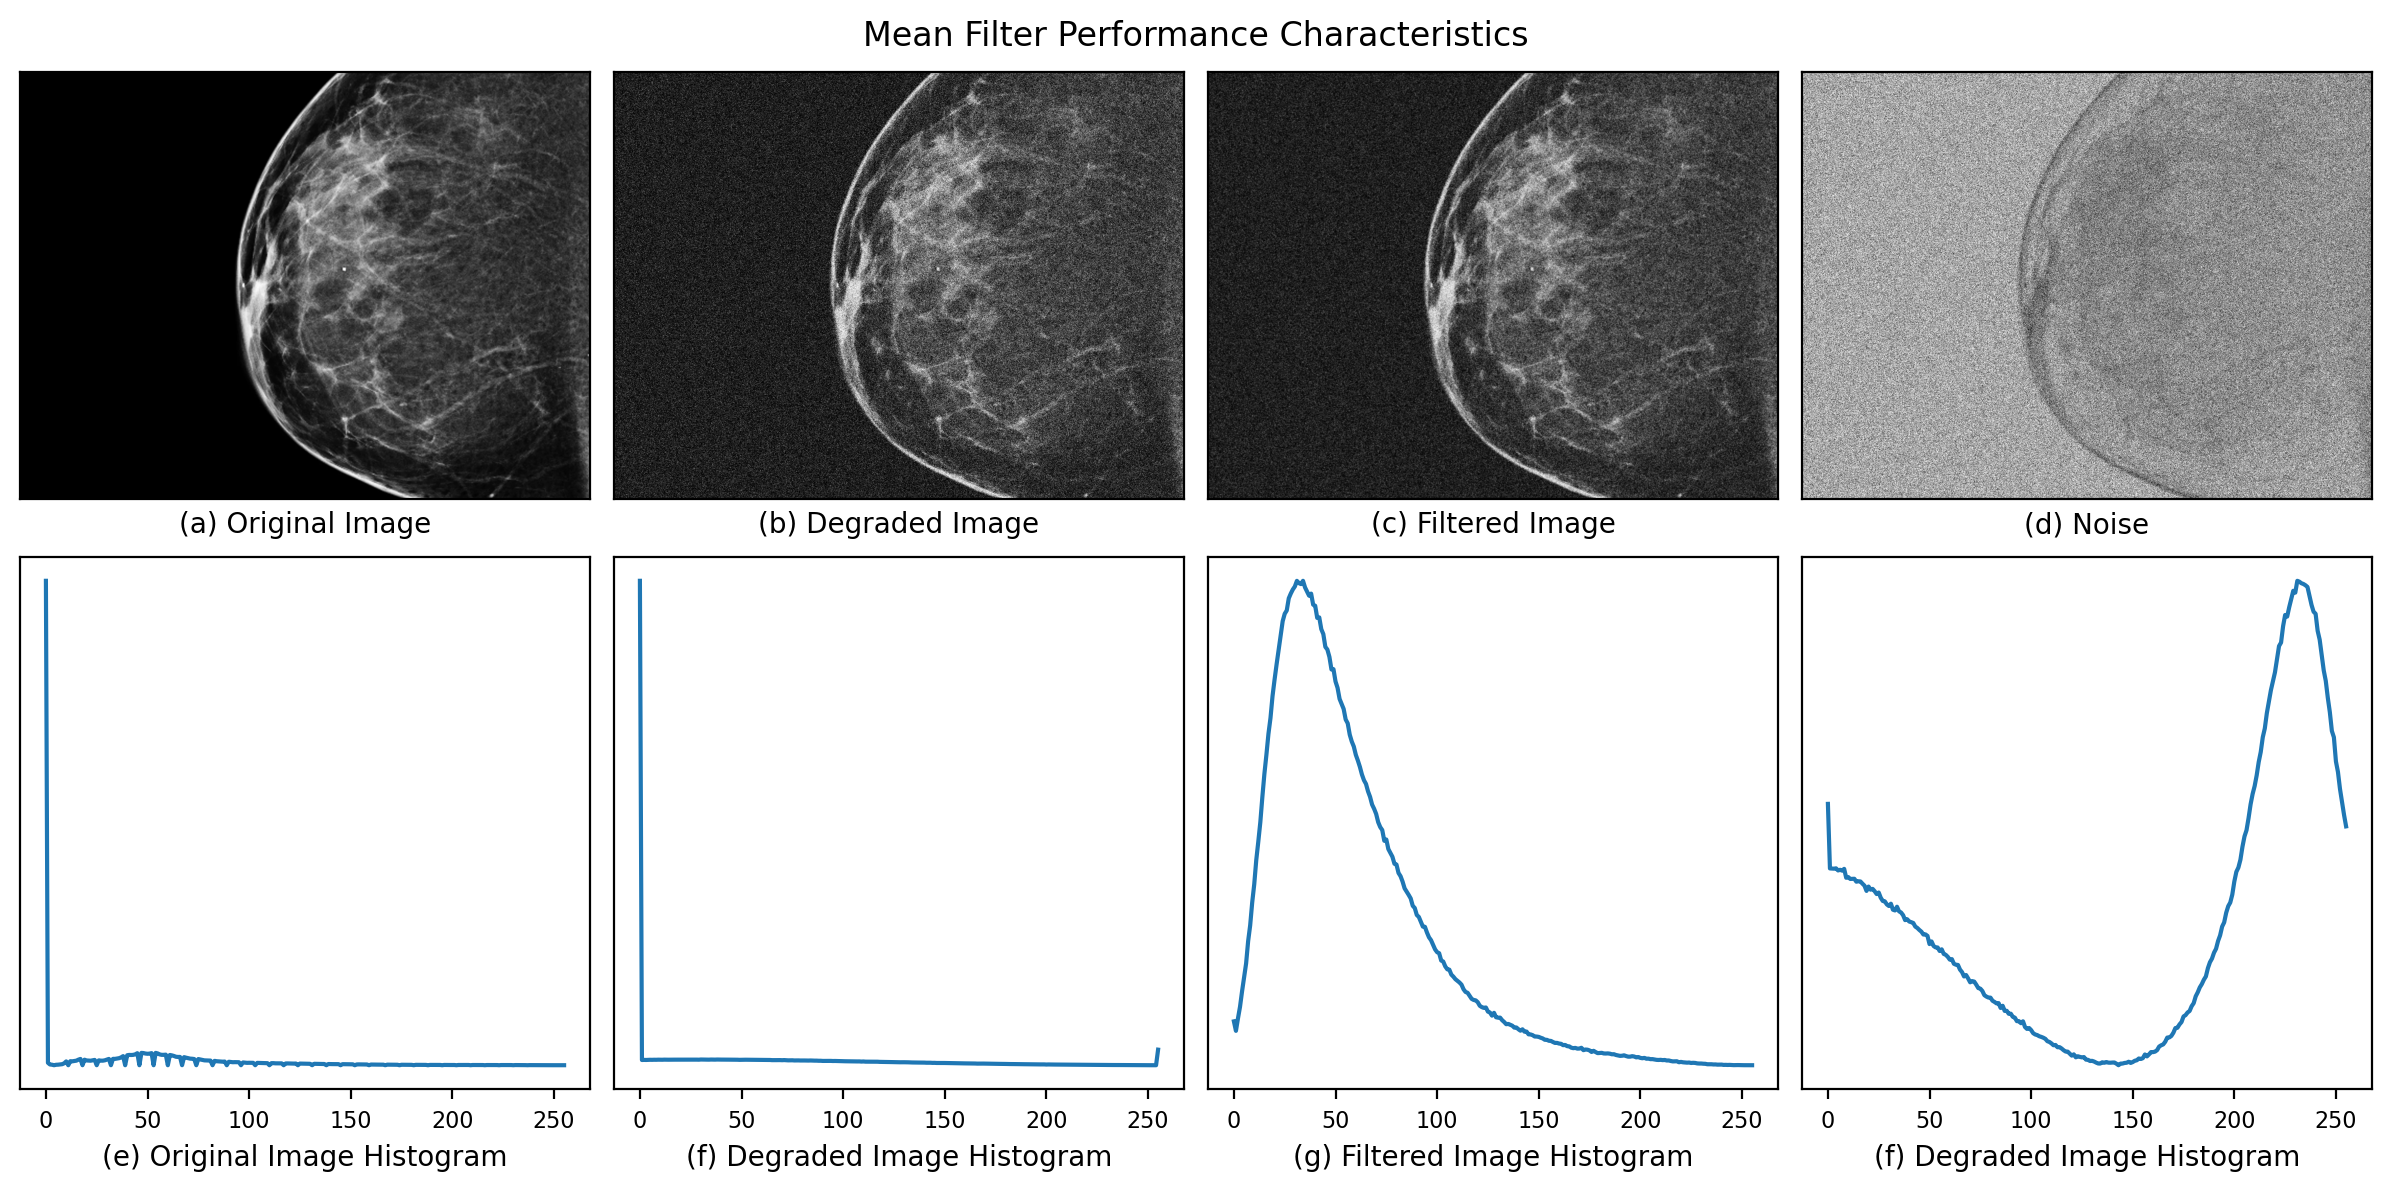

In [2]:
analyzer = MeanFilterAnalyzer()
analyzer.add_gaussian_noise()
fig = analyzer.analyze()
glue("mean_gaussian_characteristics", fig)

```{glue:figure} mean_gaussian_characteristics
---
align: center
name: mean_gaussian_characteristics_fig
---
Mean Filter Performance Analysis with Gaussian Noise
```

As shown in {numref}`mean_gaussian_characteristics_fig`, applying a 3×3 mean filter makes the image smoother, which is evident upon close examination of the features in the region of interest. The histograms illuminate the distribution of the signal vis-a-vis the noise. As (f) illustrates, most of the noise was in the brighter regions of the image.

---

Let's examine the effects of various kernel sizes on performance.

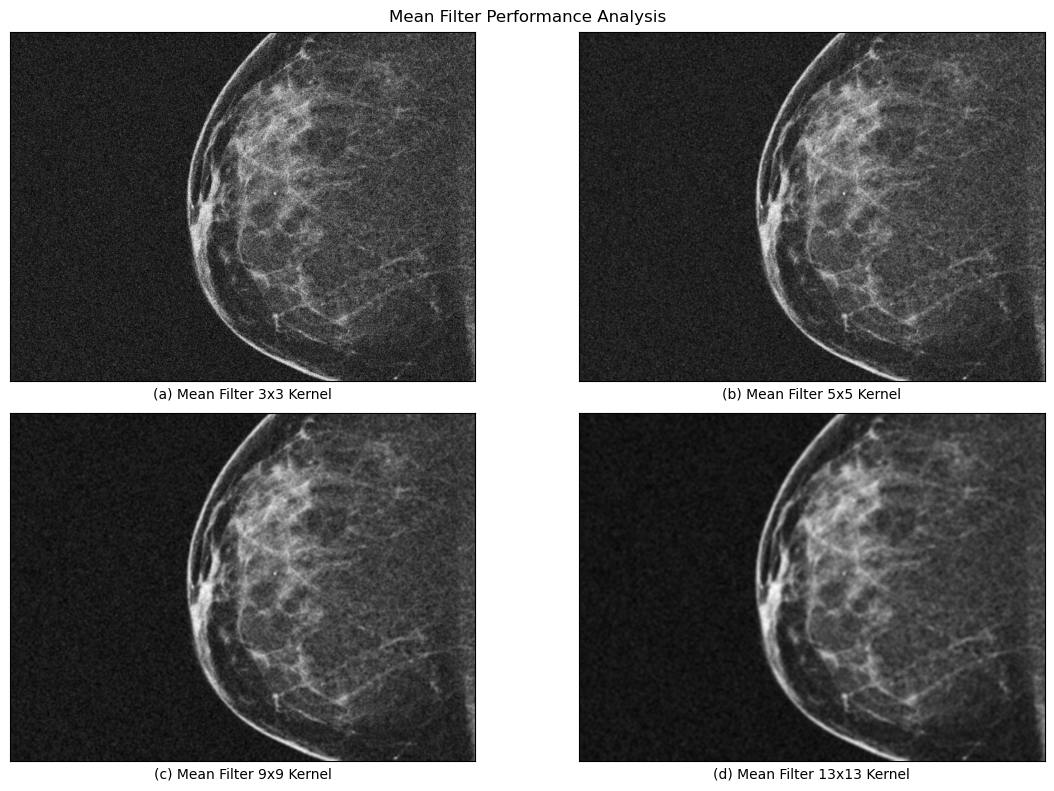

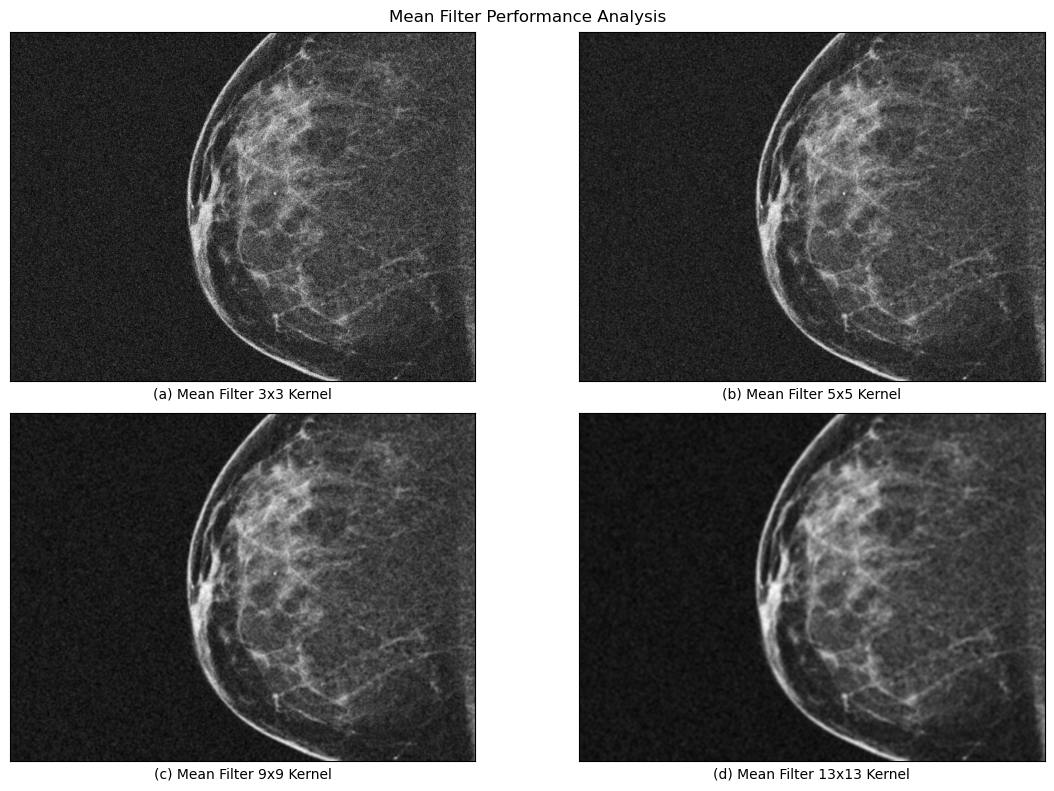

In [3]:
analyzer = MeanFilterAnalyzer()
analyzer.add_gaussian_noise()
fig = analyzer.compare()
glue("mean_gaussian_analysis", fig)

```{glue:figure} mean_gaussian_analysis
---
align: center
name: mean_gaussian_analysis_fig
---
Mean Filter Performance Characteristics with Gaussian Noise
```

###### Mean Filter - Quantization Noise

{numref}`mean_quant_characteristics_fig` illustrates the results of a 3x3 mean filter kernel on a mammogram image degraded with quantization noise.

In [4]:
analyzer = MeanFilterAnalyzer()
analyzer.add_quantization_noise()
fig = analyzer.analyze()
glue("mean_quant_characteristics", fig)

AttributeError: 'MeanFilterAnalyzer' object has no attribute 'add_quantization_noise'

```{glue:figure} mean_quant_characteristics
---
align: center
name: mean_quant_characteristics_fig
---
Mean Filter Performance Analysis with Quantization Noise
```

Let's examine the effects of various kernel sizes on performance.

In [ ]:
analyzer = MeanFilterAnalyzer()
analyzer.add_quantization_noise()
fig = analyzer.compare()
glue("mean_quant_analysis", fig)

```{glue:figure} mean_quant_analysis
---
align: center
name: mean_quant_analysis_fig
---
Mean Filter Performance Characteristics with Quantization Noise
```


###### Mean Filter - Speckle Noise

{numref}`mean_speckle_characteristics_fig` illustrates the results of a 3x3 mean filter kernel on a mammogram image degraded with speckle noise.

In [ ]:
analyzer = MeanFilterAnalyzer()
analyzer.add_speckle_noise()
fig = analyzer.analyze()
glue("mean_speckle_characteristics", fig)

```{glue:figure} mean_speckle_characteristics
---
align: center
name: mean_speckle_characteristics_fig
---
Mean Filter Performance Analysis with Speckle Noise
```

---

Let's examine the effects of various kernel sizes on performance.

In [ ]:
analyzer = MeanFilterAnalyzer()
analyzer.add_speckle_noise()
fig = analyzer.compare()
glue("mean_speckle_analysis", fig)

```{glue:figure} mean_speckle_analysis
---
align: center
name: mean_speckle_analysis_fig
---
Mean Filter Performance Characteristics with Speckle Noise
```

###### Mean Filter - Salt & Pepper Noise

{numref}`mean_snp_characteristics_fig` illustrates the results of a 3x3 mean filter kernel on a mammogram image degraded with salt and pepper noise.

In [ ]:
analyzer = MeanFilterAnalyzer()
analyzer.add_snp_noise()
fig = analyzer.analyze()
glue("mean_snp_characteristics", fig)

```{glue:figure} mean_snp_characteristics
---
align: center
name: mean_snp_characteristics_fig
---
Mean Filter Performance Analysis with Salt & Pepper Noise
```

---

Let's examine the effects of various kernel sizes on performance.

In [ ]:
analyzer = MeanFilterAnalyzer()
analyzer.add_snp_noise()
fig = analyzer.compare()
glue("mean_snp_analysis", fig)

```{glue:figure} mean_snp_analysis
---
align: center
name: mean_snp_analysis_fig
---
Mean Filter Performance Characteristics with Salt & Pepper Noise
```

###### Mean Filter - Poisson Noise

{numref}`mean_poisson_characteristics_fig` illustrates the results of a 3x3 mean filter kernel on a mammogram image degraded with Poisson noise.

In [ ]:
analyzer = MeanFilterAnalyzer()
analyzer.add_poisson_noise()
fig = analyzer.analyze()
glue("mean_poisson_characteristics", fig)

```{glue:figure} mean_poisson_characteristics
---
align: center
name: mean_poisson_characteristics_fig
---
Mean Filter Performance Analysis with Poisson Noise
```

---

Let's examine the effects of various kernel sizes on performance.

In [ ]:
analyzer = MeanFilterAnalyzer()
analyzer.add_poisson_noise()
fig = analyzer.compare()
glue("mean_poisson_analysis", fig)

```{glue:figure} mean_poisson_analysis
---
align: center
name: mean_poisson_analysis_fig
---
Mean Filter Performance Characteristics with Poisson Noise
```